In [69]:
import torch
from torch import Tensor
from torch.nn import *
from torch.optim import Adam
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.nn.functional import interpolate, avg_pool2d
import numpy as np
from random import random
from typing import Any, Dict, Optional
import matplotlib.pyplot as plt
import pickle

In [103]:
def save_loss(tab_of_loss, path="./"):
    with open(path+"tab_of_loss", "wb") as floss:
        pickle.dump(tab_of_loss, floss)

In [96]:
dataroot = "/home/goliot/project/deep_learning_project/img_align_celeba"

batch_size = 20
image_size = 128
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

"""real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to("cpu")[:64], padding=2, normalize=True).cpu(),(1,2,0)))"""

'real_batch = next(iter(dataloader))\nplt.figure(figsize=(8,8))\nplt.axis("off")\nplt.title("Training Images")\nplt.imshow(np.transpose(vutils.make_grid(real_batch[0].to("cpu")[:64], padding=2, normalize=True).cpu(),(1,2,0)))'

In [41]:
def nf(
    stage: int,
    fmap_base: int = 16 << 10,
    fmap_decay: float = 1.0,
    fmap_min: int = 1,
    fmap_max: int = 512,
) -> int:
    """
    computes the number of fmaps present in each stage
    Args:
        stage: stage level
        fmap_base: base number of fmaps
        fmap_decay: decay rate for the fmaps in the network
        fmap_min: minimum number of fmaps
        fmap_max: maximum number of fmaps
    Returns: number of fmaps that should be present there
    """
    return int(
        np.clip(
            int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max,
        ).item()
    )


256


## Pixel Wise Norm

In [42]:
class PixelwiseNorm(Module):
    """
    ------------------------------------------------------------------------------------
    Pixelwise feature vector normalization.
    reference:
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
    ------------------------------------------------------------------------------------
    """

    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    @staticmethod
    def forward(x: Tensor, alpha: float = 1e-8) -> Tensor:
        y = x.pow(2.0).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

## Equalized Conv Transpose 2d

In [43]:
class EqualizedConvTranspose2d(ConvTranspose2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        output_padding=0,
        groups=1,
        bias=True,
        dilation=1,
        padding_mode="zeros",
    ) -> None:
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            output_padding,
            groups,
            bias,
            dilation,
            padding_mode,
        )
        # make sure that the self.weight and self.bias are initialized according to
        # random normal distribution
        torch.nn.init.normal_(self.weight)
        if bias:
            torch.nn.init.zeros_(self.bias)

        # define the scale for the weights:
        fan_in = self.in_channels
        self.scale = np.sqrt(2) / np.sqrt(fan_in)

    def forward(self, x: Tensor, output_size: Any = None) -> Tensor:
        output_padding = self._output_padding(
            input, output_size, self.stride, self.padding, self.kernel_size
        )
        return torch.conv_transpose2d(
            input=x,
            weight=self.weight * self.scale,  # scale the weight on runtime
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            output_padding=output_padding,
            groups=self.groups,
            dilation=self.dilation,
        )

## Equalized Conv 2d

In [44]:

class EqualizedConv2d(Conv2d):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        bias=True,
        padding_mode="zeros",
    ) -> None:
        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
        )
        # make sure that the self.weight and self.bias are initialized according to
        # random normal distribution
        torch.nn.init.normal_(self.weight)
        if bias:
            torch.nn.init.zeros_(self.bias)

        # define the scale for the weights:
        fan_in = np.prod(self.kernel_size) * self.in_channels
        self.scale = np.sqrt(2) / np.sqrt(fan_in)

    def forward(self, x: Tensor) -> Tensor:
        return torch.conv2d(
            input=x,
            weight=self.weight * self.scale,  # scale the weight on runtime
            bias=self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups,
        )

## Generator Initial Block

In [45]:
class GenInitialBlock(Module):
    """
    Module implementing the initial block of the input
    Args:
        in_channels: number of input channels to the block
        out_channels: number of output channels of the block
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(GenInitialBlock, self).__init__()
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d
        ConvTransposeBlock = EqualizedConvTranspose2d if use_eql else ConvTranspose2d

        self.conv_1 = ConvTransposeBlock(in_channels, out_channels, (4, 4), bias=True)
        self.conv_2 = ConvBlock(
            out_channels, out_channels, (3, 3), padding=1, bias=True
        )
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = torch.unsqueeze(torch.unsqueeze(x, -1), -1)
        y = self.pixNorm(y)  # normalize the latents to hypersphere
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.pixNorm(y)
        return y

## Genrator General Block

In [46]:
class GenGeneralConvBlock(Module):
    """
    Module implementing a general convolutional block
    Args:
        in_channels: number of input channels to the block
        out_channels: number of output channels required
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(GenGeneralConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(in_channels, out_channels, (3, 3), padding=1, bias=True)
        self.conv_2 = ConvBlock(
            out_channels, out_channels, (3, 3), padding=1, bias=True
        )
        self.pixNorm = PixelwiseNorm()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = interpolate(x, scale_factor=2)
        y = self.pixNorm(self.lrelu(self.conv_1(y)))
        y = self.pixNorm(self.lrelu(self.conv_2(y)))

        return y

## Discriminator Final block

In [47]:
class DisFinalBlock(torch.nn.Module):
    """
    Final block for the Discriminator
    Args:
        in_channels: number of input channels
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(DisFinalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(
            in_channels + 1, in_channels, (3, 3), padding=1, bias=True
        )
        # (16 - 3 + 2 / 1) + 1 = 16
        self.conv_2 = ConvBlock(in_channels, out_channels, (4, 4), bias=True)
        # (16 - 4 / 1) + 1 = 13
        self.conv_3 = ConvBlock(out_channels, 1, (1, 1), bias=True)
        self.batch_discriminator = MinibatchStdDev()
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = self.batch_discriminator(x)
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))
        y = self.conv_3(y)
        return y.view(20, -1)

## Discriminator General Conv Block

In [48]:
class DisGeneralConvBlock(Module):
    """
    General block in the discriminator
    Args:
        in_channels: number of input channels
        out_channels: number of output channels
        use_eql: whether to use equalized learning rate
    """

    def __init__(self, in_channels: int, out_channels: int, use_eql: bool) -> None:
        super(DisGeneralConvBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.use_eql = use_eql

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.conv_1 = ConvBlock(in_channels, in_channels, (3, 3), padding=1, bias=True)
        self.conv_2 = ConvBlock(in_channels, out_channels, (3, 3), padding=1, bias=True)
        self.downSampler = AvgPool2d(2)
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x: Tensor) -> Tensor:
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)
        return y

## Minibatch Standart deviation

In [49]:
class MinibatchStdDev(torch.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    Args:
        group_size: Size of each group into which the batch is split
    """

    def __init__(self, group_size: int = 4) -> None:
        """
        Args:
            group_size: Size of each group into which the batch is split
        """
        super(MinibatchStdDev, self).__init__()
        self.group_size = group_size

    def extra_repr(self) -> str:
        return f"group_size={self.group_size}"

    def forward(self, x: Tensor, alpha: float = 1e-8) -> Tensor:
        """
        forward pass of the layer
        Args:
            x: input activation volume
            alpha: small number for numerical stability
        Returns: y => x appended with standard deviation constant map
        """
        batch_size, channels, height, width = x.shape
        if batch_size > self.group_size:
            assert batch_size % self.group_size == 0, (
                f"batch_size {batch_size} should be "
                f"perfectly divisible by group_size {self.group_size}"
            )
            group_size = self.group_size
        else:
            group_size = batch_size

        # reshape x into a more amenable sized tensor
        y = torch.reshape(x, [group_size, -1, channels, height, width])

        # indicated shapes are after performing the operation
        # [G x M x C x H x W] Subtract mean over groups
        y = y - y.mean(dim=0, keepdim=True)

        # [M x C x H x W] Calc standard deviation over the groups
        y = torch.sqrt(y.square().mean(dim=0, keepdim=False) + alpha)

        # [M x 1 x 1 x 1]  Take average over feature_maps and pixels.
        y = y.mean(dim=[1, 2, 3], keepdim=True)

        # [B x 1 x H x W]  Replicate over group and pixels
        y = y.repeat(group_size, 1, height, width)

        # [B x (C + 1) x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)

        # return the computed values:
        return y

## Split image

In [50]:
def split_image(x, i, n):
    hw = x.shape[3] + 1
    assert ((hw - 1) - n) % i == 0 and (hw - 1) > n, "Error"
    new_img = []
    x = x.numpy()
    for image in x:
        for line in range(0, hw - n, 1):
            for stride in range(0, hw - n, i):
                new_img.append(image[:, line:line + n, stride:stride + n])
    new_img = np.array(new_img)
    return torch.from_numpy(new_img)

## Generator

In [51]:
class Generator(Module):
    def __init__(self, in_channels, out_channels, use_eql):
        super().__init__()

        ConvBlock = EqualizedConv2d if use_eql else Conv2d
        self.gen_block = ModuleList([GenGeneralConvBlock(nf(8), nf(9), use_eql)])

        self.rgb_converters = ModuleList(
            [
                ConvBlock(nf(9), 3, kernel_size=(1, 1))
            ]
        )

    def forward(self, x):
        for layer in self.gen_block:
            x = layer(x)
        x = self.rgb_converters[0](x)
        return x

In [52]:
def addGenBlock(generator, depth):
    for param in generator.gen_block[0].parameters():
        param.requires_grad = False
    generator.gen_block.insert(0, GenGeneralConvBlock(nf(depth), nf(depth+1), False))
    """i = 0
    for block in model.gen_block:
        print(f"Block {i} : ")
        i += 1
        for param in block.parameters():
            print(f"Requires grad : {param.requires_grad}")
        print("\n")"""

## Discriminator

In [53]:
class Discriminator(Module):
    def __init__(self, latent_size=512, depth=7, use_eql=False):
        super().__init__()
        self.latent_size = latent_size
        self.dis_block = ModuleList([DisFinalBlock(nf(1), latent_size, use_eql)])

        ConvBlock = EqualizedConv2d if use_eql else Conv2d

        self.from_rgb = ModuleList(
            reversed(
                [
                    ConvBlock(3, latent_size, kernel_size=(1, 1))
                ]
            )
        )

    def forward(self, x):
        x = self.from_rgb[0](x)
        for layer in self.dis_block:
            x = layer(x)
        return x


## Add Discriminator Block

In [54]:
def addDisBlock(discriminator, depth):
    for param in discriminator.dis_block[0].parameters():
        param.requires_grad = False
    discriminator.dis_block.insert(0, DisGeneralConvBlock(nf(depth), nf(depth+1), False))

## Create DCGAN class

In [104]:
class DCGAN():
    def __init__(self, noise_fn, dataloader, device, batch_size=20, lr_g=1e-3, lr_d=2e-4, depth=7):
        self.dataloader = dataloader
        self.device = device
        self.generator = Generator(1, 3, False).to(device)
        self.discriminator = Discriminator().to(device)
        self.noise_fn = noise_fn
        self.batch_size = batch_size

        self.criterion = BCEWithLogitsLoss()
        self.g_optimizer = Adam(self.generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
        self.d_optimizer = Adam(self.discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

        self.target_ones = torch.ones(batch_size, 1)
        self.target_zeros = torch.zeros(batch_size, 1)

    def create_sample(self):
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            samples = self.generator(latent_vec)
        samples = samples.cpu()
        return samples

    def train_step_generator(self):
        self.generator.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        fake_sample = self.generator(latent_vec)
        prediction = self.discriminator(fake_sample)
        loss = self.criterion(prediction, self.target_ones)
        loss.backward()
        self.g_optimizer.step()

        return loss.item()

    def train_step_discriminator(self, real_sample):
        #self.discriminator.zero_grad()
        pred_real = self.discriminator(real_sample)
        loss_real = self.criterion(pred_real, self.target_ones)
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_sample = self.generator(latent_vec)
        fake_pred = self.discriminator(fake_sample)
        loss_fake = self.criterion(fake_pred, self.target_zeros)

        loss = (loss_real + loss_fake) / 2
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss_real.item(), loss_fake.item()

    def train_gan(self, stride, kernel_size, epoch_train_d):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        array_loss = [[], [], []]
        for batch_i, (image, _) in enumerate(self.dataloader):
            image = split_image(image, stride, kernel_size)
            dataloader_split = torch.utils.data.DataLoader(image, batch_size=batch_size,
                                                           shuffle=True)
            for batch_si, image in enumerate(dataloader_split):
                image = image.to(self.device)
                for i in range(epoch_train_d):
                    ldr, ldf = self.train_step_discriminator(image)
                    loss_d_fake_running += ldf
                    loss_d_real_running += ldr
                loss_g_running += self.train_step_generator()
                break
            break
            if batch_i % 100 == 99:
                array_loss[0].append(loss_g_running/((batch_i+1)*(batch_si+1)))
                array_loss[1].append(loss_d_real_running/((batch_i+1)*((batch_si+1)*epoch_train_d)))
                array_loss[2].append(loss_d_fake_running/((batch_i+1)*((batch_si+1)*epoch_train_d)))
        return np.array(array_loss)


## Main Function

In [105]:
def main(dataloader, ngpu=0, path="./"):
    batch_size = 20
    epochs = 1
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    latent_size = 4
    noise_fn = lambda x: torch.randn(x, 64, 2, 2)
    gan = DCGAN(noise_fn=noise_fn, dataloader=dataloader, device=device, batch_size=batch_size)
    tab_loss = []
    for i in range(epochs):
        loss = (gan.train_gan(2, 4, 5))
        tab_loss.append(loss)
    gan.generator.to("cpu")
    gan.discriminator.to("cpu")
    torch.save({
        "generator":gan.generator.state_dict(),
        "discriminator":gan.discriminator.state_dict()
    }, (path +"gen_disc.pth"))
    save_loss(tab_loss)
    return loss


In [106]:
loss = main(dataloader)

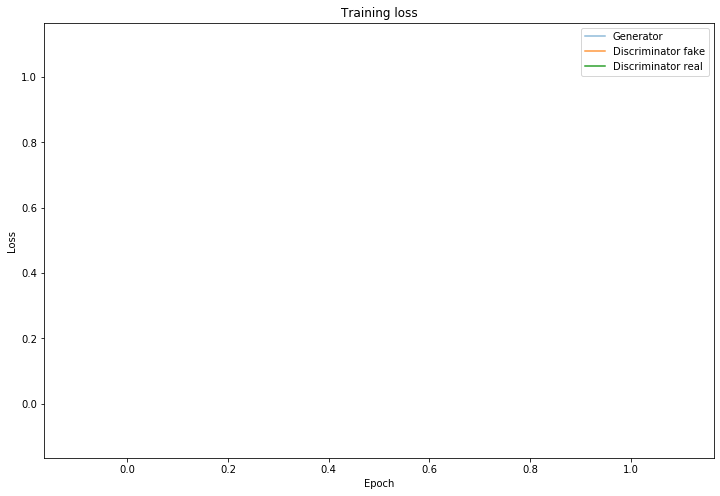

In [109]:
def display_loss(loss):
    fix, axe = plt.subplots(figsize=(12, 8))
    plt.plot(loss[0], label="Generator", alpha=0.5)
    plt.plot(loss[1], label="Discriminator fake", alpha=0.8)
    plt.plot(loss[2],  label="Discriminator real")
    plt.title("Training loss")
    axe.set_ylabel("Loss")
    axe.set_xlabel("Epoch")
    plt.legend()
display_loss(loss)